In [1]:
import time
import torch
import copy
from torch.distributions import Categorical, kl
from d2l.torch import Animator
import torch
from torch.nn import functional as F
import numpy as np
from tqdm.auto import tqdm
import wandb


from net import Net
from faco import FACO, route_cost_flat
from utils import gen_pyg_data, gen_instance

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T = 5
device = 'cuda:0'

# ------------------------------------------------------------
# Hyperparams (tune)
# ------------------------------------------------------------
ROLLOUT_STEPS = 4          # n-step FACO iterations per instance rollout
PPO_EPOCHS = 2             # PPO epochs per rollout batch
MINIBATCH_SIZE = 256       # number of ant-trajectories per PPO minibatch

INV_TEMP = 1.0
CLIP_RATIO = 0.2
VALUE_COEFF = 0.5
ENTROPY_COEFF = 0.01
MAX_GRAD_NORM = 3.0

# FACO params
K_NEAREST = 20
MIN_NEW_EDGES = 8
SAMPLE_TWO_OPT = True

In [2]:
def warmup_steps_schedule(epoch: int,
                          warmup_min=0,
                          warmup_max=50,
                          warmup_ramp_epochs=50):
    # linear ramp: 0 -> warmup_max over warmup_ramp_epochs
    frac = min(1.0, epoch / max(1, warmup_ramp_epochs))
    return int(round(warmup_min + (warmup_max - warmup_min) * frac))


@torch.no_grad()
def faco_warmup(solver, pyg_base, model, warmup_steps, invtemp=1.0):
    model.eval()
    for _ in range(warmup_steps):
        ref_flat = solver.best_flat.copy()
        tau = solver.pheromone_sparse.detach().clone()

        pyg = copy.copy(pyg_base)
        pyg = attach_faco_state_to_pyg(pyg, solver, ref_flat, tau, model)

        out = model(pyg, return_value=False) if "return_value" in model.forward.__code__.co_varnames else model(pyg)
        heu_vec = out[0] if isinstance(out, (tuple, list)) else out
        heu_full = model.reshape(pyg, heu_vec) + 1e-10
        solver.set_heuristic(heu_full)

        costs_np, flats, _touched = solver.sample(invtemp=invtemp, require_prob=False)

        best_i = int(np.argmin(costs_np))
        best_cost = float(costs_np[best_i])
        best_flat = flats[best_i]

        if best_cost < solver.best_cost:
            solver.best_cost = best_cost
            solver.best_flat = best_flat

        solver._update_pheromone_from_flat(best_flat, best_cost)


def _edge_feat_in_dim(model, pyg):
    # detect what emb_net expects
    if hasattr(model, "emb_net") and hasattr(model.emb_net, "e_lin0"):
        return int(model.emb_net.e_lin0.in_features)
    # fallback: whatever pyg currently holds
    print("Warning: detecting edge feature input dim from pyg.edge_attr")
    if pyg.edge_attr is None:
        return 1
    return int(pyg.edge_attr.size(-1))


def attach_faco_state_to_pyg(pyg_base, solver, ref_flat, tau_sparse, model):
    """
    Returns a pyg Data object with edge_attr augmented based on FACO state:
      - dist (always)
      - in_best edge indicator (optional)
      - pheromone value (optional)
    """
    pyg = pyg_base  # mutate in place

    device = pyg.x.device
    n = solver.n

    # base distance feature (E,1)
    dist_feat = pyg.edge_attr
    if dist_feat is None:
        u = pyg.edge_index[0]
        v = pyg.edge_index[1]
        dist_feat = solver.dist_t[u, v].unsqueeze(-1)
    else:
        if dist_feat.dim() == 1:
            dist_feat = dist_feat.unsqueeze(-1)
        if dist_feat.size(-1) > 1:
            dist_feat = dist_feat[:, :1]

    in_dim = _edge_feat_in_dim(model=model, pyg=pyg)

    if in_dim == 1:
        pyg.edge_attr = dist_feat
        return pyg

    # best-edge mask
    best_adj = torch.zeros((n, n), device=device, dtype=torch.float32)
    u_b = torch.tensor(ref_flat[:-1], device=device, dtype=torch.long)
    v_b = torch.tensor(ref_flat[1:], device=device, dtype=torch.long)
    best_adj[u_b, v_b] = 1.0

    u_e = pyg.edge_index[0]
    v_e = pyg.edge_index[1]
    in_best = best_adj[u_e, v_e].unsqueeze(-1)  # (E,1)

    if in_dim == 2:
        pyg.edge_attr = torch.cat([dist_feat, in_best], dim=-1)
        return pyg

    # pheromone on edges
    nn = torch.from_numpy(solver.nn_list).to(device)  # (n,k)
    rows = torch.arange(n, device=device).unsqueeze(1).expand(n, solver.k)
    tau_full = torch.zeros((n, n), device=device, dtype=torch.float32)
    tau_full[rows, nn.clamp_min(0)] = tau_sparse.detach().clamp_min(1e-10)

    tau_e = tau_full[u_e, v_e].unsqueeze(-1)

    pyg.edge_attr = torch.cat([dist_feat, in_best, tau_e], dim=-1)
    return pyg


In [3]:
# ------------------------------------------------------------
# Rollout collector
# ------------------------------------------------------------
rollout_bar = None

@torch.no_grad()
def faco_rollout_collect(n, model, n_ants, rollout_steps=ROLLOUT_STEPS, warmup_steps = 0):
    """
    Collect a rollout of length rollout_steps.
    Returns a list of experience dicts (one per ant trajectory per step),
    and also a fresh solver (for debug/optional usage).
    """
    model.eval()

    demands, distances = gen_instance(n, device)              # torch
    pyg_base = gen_pyg_data(demands, distances, device)       # torch_geometric.data.Data

    solver = FACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        k_nearest=K_NEAREST,
        capacity=int(getattr(__import__("aco"), "CAPACITY", 50)) if False else 50,  # keep 50 unless you override
        decay=0.9,
        alpha=1.0,
        beta=1.0,
        min_new_edges=MIN_NEW_EDGES,
        sample_two_opt=SAMPLE_TWO_OPT,
        device=device,
    )

    if warmup_steps > 0:
        faco_warmup(solver, pyg_base, model, warmup_steps, invtemp=INV_TEMP)

    exps = []
    rollout_bar = tqdm(range(rollout_steps), desc="Rollout", unit="step")

    for t in rollout_bar:
        # snapshot state for replay
        ref_flat = solver.best_flat.copy()
        tau_snap = solver.pheromone_sparse.detach().clone()

        # build pyg with state-features
        pyg = copy.copy(pyg_base)
        pyg = attach_faco_state_to_pyg(pyg, solver, ref_flat, tau_snap, model)

        # forward -> heuristic + value
        out = model(pyg, return_value=True) if "return_value" in model.forward.__code__.co_varnames else model(pyg)
        if isinstance(out, tuple) or isinstance(out, list):
            heu_vec, vpred = out
        else:
            heu_vec, vpred = out, torch.zeros((), device=device)

        # heuristics -> full matrix -> solver.set_heuristic
        heu_full = model.reshape(pyg, heu_vec) + 1e-10
        solver.set_heuristic(heu_full)

        # sample (old policy) from FACO
        costs_np, flats, touched, old_logps, traces = solver.sample(invtemp=INV_TEMP, require_prob=True)

        rewards = -torch.tensor(costs_np, device=device, dtype=torch.float32) # (n_ants,)


        # store each ant trajectory as one PPO sample
        # vpred should be scalar baseline for this state
        if torch.is_tensor(vpred) and vpred.numel() > 1:
            vpred_scalar = vpred.mean()
        else:
            vpred_scalar = vpred.reshape(())

        for i in range(n_ants):
            exps.append({
                "ref_flat": ref_flat,              # numpy
                "tau": tau_snap,                   # torch (n,k)
                "old_logp": old_logps[i].detach(), # torch scalar
                "reward": rewards[i].detach(),     # torch scalar
                "trace": traces[i],                # FACOTrace
                "pyg_base": pyg_base,              # static graph
                "distances": distances,            # torch
                "demands": demands,                # torch
            })

        # advance environment exactly like one FACO iteration
        best_i = int(np.argmin(costs_np))
        best_cost = float(costs_np[best_i])
        best_flat = flats[best_i]

        if best_cost < solver.best_cost:
            solver.best_cost = best_cost
            solver.best_flat = best_flat

        solver._update_pheromone_from_flat(best_flat, best_cost)

        rollout_bar.set_postfix({"best_cost": f"{solver.best_cost:.4f}"})

    return exps


# ------------------------------------------------------------
# PPO update using replay_logp
# ------------------------------------------------------------
def ppo_update_from_exps(model, optimizer, exps, clip_ratio=CLIP_RATIO,
                         value_coeff=VALUE_COEFF, entropy_coeff=ENTROPY_COEFF):
    model.train()

    # shuffle indices
    idx = torch.randperm(len(exps))
    exps = [exps[i] for i in idx.tolist()]

    total_policy = 0.0
    total_value = 0.0
    total_ent = 0.0
    total_loss = 0.0
    n_batches = 0

    for _ in range(PPO_EPOCHS):
        for start in range(0, len(exps), MINIBATCH_SIZE):
            batch = exps[start:start + MINIBATCH_SIZE]
            if len(batch) == 0:
                continue

            policy_losses = []
            value_losses = []
            entropies = []

            for item in batch:
                distances = item["distances"]
                demands = item["demands"]

                # reconstruct a solver for this sample state (cheap for n<=101; optimize later)
                solver = FACO(
                    distances=distances,
                    demand=demands,
                    n_ants=1,  # we replay one trace at a time
                    k_nearest=K_NEAREST,
                    capacity=50,
                    decay=0.9,
                    alpha=1.0,
                    beta=1.0,
                    min_new_edges=MIN_NEW_EDGES,
                    sample_two_opt=False,  # LS not part of logπ; keep off for replay stability
                    device=device,
                )

                # restore state snapshot
                ref_flat = item["ref_flat"]
                solver.best_flat = ref_flat
                solver.pheromone_sparse = item["tau"].detach().clone()

                # build pyg with restored state features
                pyg_base = item["pyg_base"]
                pyg = copy.copy(pyg_base)
                pyg = attach_faco_state_to_pyg(pyg, solver, ref_flat, solver.pheromone_sparse, model)

                # forward current policy
                out = model(pyg, return_value=True) if "return_value" in model.forward.__code__.co_varnames else model(pyg)
                if isinstance(out, tuple) or isinstance(out, list):
                    heu_vec, vpred = out
                else:
                    heu_vec, vpred = out, torch.zeros((), device=device)

                heu_full = model.reshape(pyg, heu_vec) + 1e-10
                solver.set_heuristic(heu_full)

                # new logp from replay
                new_logp = solver.replay_logp(
                    item["trace"],
                    invtemp=INV_TEMP,
                    ref_flat=ref_flat,
                    prob_sparse=solver.prob_sparse_torch(INV_TEMP),
                )

                old_logp = item["old_logp"]
                reward = item["reward"]

                # value scalar
                if torch.is_tensor(vpred) and vpred.numel() > 1:
                    vpred_scalar = vpred.mean()
                else:
                    vpred_scalar = vpred.reshape(())

                # advantage (simple one-step, terminal reward)
                adv = (reward - vpred_scalar.detach())
                # optional normalization inside minibatch
                # (comment out if you already shared-energy-normalize elsewhere)
                # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

                ratio = torch.exp(new_logp - old_logp)
                surr1 = ratio * adv
                surr2 = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * adv
                policy_loss = -torch.min(surr1, surr2)

                value_loss = F.mse_loss(vpred_scalar, reward)


                # entropy bonus (coarse): entropy of normalized prob_sparse rows
                prob = solver.prob_sparse_torch(INV_TEMP)
                prob = prob / (prob.sum(dim=1, keepdim=True) + 1e-10)
                entropy = -(prob * torch.log(prob + 1e-10)).sum(dim=1).mean()

                policy_losses.append(policy_loss)
                value_losses.append(value_loss)
                entropies.append(entropy)

            policy_loss = torch.stack(policy_losses).mean()
            value_loss = torch.stack(value_losses).mean()
            entropy = torch.stack(entropies).mean()

            loss = policy_loss + value_coeff * value_loss - entropy_coeff * entropy

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()

            total_policy += float(policy_loss.detach().cpu())
            total_value += float(value_loss.detach().cpu())
            total_ent += float(entropy.detach().cpu())
            total_loss += float(loss.detach().cpu())
            n_batches += 1

    return {
        "policy_loss": total_policy / max(1, n_batches),
        "value_loss": total_value / max(1, n_batches),
        "entropy": total_ent / max(1, n_batches),
        "total_loss": total_loss / max(1, n_batches),
    }


# ------------------------------------------------------------
# Train step: collect rollout + PPO update
# ------------------------------------------------------------
def train_instance_ppo(epoch, n, model, optimizer, n_ants):
    warmup_steps = warmup_steps_schedule(epoch, warmup_min=0, warmup_max=50, warmup_ramp_epochs=30)
    exps = faco_rollout_collect(n, model, n_ants, rollout_steps=ROLLOUT_STEPS, warmup_steps=warmup_steps)
    stats = ppo_update_from_exps(model, optimizer, exps)
    stats["warmup_steps"] = warmup_steps
    return stats




In [4]:
epoch_bar = None
# ------------------------------------------------------------

def train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer, epoch):
    stats_acc = {"policy_loss": 0.0, "value_loss": 0.0, "entropy": 0.0, "total_loss": 0.0, "warmup_steps": 0.0}
    epoch_bar = tqdm(range(steps_per_epoch), desc="Training", unit="step")
    for step in epoch_bar:
        st = train_instance_ppo(epoch, n_node, net, optimizer, n_ants)
        for k in stats_acc:
            stats_acc[k] += st[k]
        epoch_bar.set_postfix({k: f"{stats_acc[k]/(step+1):.4f}" for k in stats_acc})
        
        # Log per-step metrics to wandb
        wandb.log({
            f"train/step_{k}": v 
            for k, v in st.items()
        }, step=epoch * steps_per_epoch + step)
        
    for k in stats_acc:
        stats_acc[k] /= max(1, steps_per_epoch)
    return stats_acc

# ------------------------------------------------------------
# Validation: run FACO for T steps, refreshing heuristic each step
# ------------------------------------------------------------
@torch.no_grad()
def validation(n_node, n_ants, net, n_val=50, T_eval=5):
    net.eval()
    sum_bl = 0.0
    sum_best = 0.0
    sum_faco = 0.0

    for _ in range(n_val):
        demands, distances = gen_instance(n_node, device)
        pyg_base = gen_pyg_data(demands, distances, device)

        solver = FACO(
            distances=distances,
            demand=demands,
            n_ants=n_ants,
            k_nearest=K_NEAREST,
            capacity=50,
            decay=0.9,
            alpha=1.0,
            beta=1.0,
            min_new_edges=MIN_NEW_EDGES,
            sample_two_opt=SAMPLE_TWO_OPT,
            device=device,
        )

        # baseline (first step sampling mean)
        ref_flat = solver.best_flat.copy()
        tau = solver.pheromone_sparse.detach().clone()
        pyg = copy.copy(pyg_base)
        pyg = attach_faco_state_to_pyg(pyg, solver, ref_flat, tau, model=net)
        out = net(pyg, return_value=True) if "return_value" in net.forward.__code__.co_varnames else net(pyg)
        heu_vec = out[0] if isinstance(out, (tuple, list)) else out
        heu_full = net.reshape(pyg, heu_vec) + 1e-10
        solver.set_heuristic(heu_full)

        costs_np, flats, _touched = solver.sample(invtemp=INV_TEMP, require_prob=False)
        sum_bl += float(np.mean(costs_np))
        sum_best += float(np.min(costs_np))

        # run T_eval steps, refreshing heuristic each step
        for _t in range(T_eval):
            ref_flat = solver.best_flat.copy()
            tau = solver.pheromone_sparse.detach().clone()

            pyg = copy.copy(pyg_base)
            pyg = attach_faco_state_to_pyg(pyg, solver, ref_flat, tau, model=net)

            out = net(pyg, return_value=True) if "return_value" in net.forward.__code__.co_varnames else net(pyg)
            heu_vec = out[0] if isinstance(out, (tuple, list)) else out
            heu_full = net.reshape(pyg, heu_vec) + 1e-10
            solver.set_heuristic(heu_full)

            costs_np, flats, _touched = solver.sample(invtemp=INV_TEMP, require_prob=False)
            best_i = int(np.argmin(costs_np))
            best_cost = float(costs_np[best_i])
            best_flat = flats[best_i]

            if best_cost < solver.best_cost:
                solver.best_cost = best_cost
                solver.best_flat = best_flat
            solver._update_pheromone_from_flat(best_flat, best_cost)

        sum_faco += float(solver.best_cost)

    return sum_bl / n_val, sum_best / n_val, sum_faco / n_val


In [5]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    # Initialize wandb
    wandb.init(
        project="ngfaco-cvrp",
        name=f"cvrp{n_node}_ppo_nstep",
        config={
            "n_node": n_node,
            "n_ants": n_ants,
            "steps_per_epoch": steps_per_epoch,
            "epochs": epochs,
            "lr": lr,
            "rollout_steps": ROLLOUT_STEPS,
            "ppo_epochs": PPO_EPOCHS,
            "minibatch_size": MINIBATCH_SIZE,
            "inv_temp": INV_TEMP,
            "clip_ratio": CLIP_RATIO,
            "value_coeff": VALUE_COEFF,
            "entropy_coeff": ENTROPY_COEFF,
            "max_grad_norm": MAX_GRAD_NORM,
            "k_nearest": K_NEAREST,
            "min_new_edges": MIN_NEW_EDGES,
            "sample_two_opt": SAMPLE_TWO_OPT,
            "T_eval": T,
        }
    )
    
    net = Net(value_head=True).to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    val_best = 1e30
    bar = tqdm(range(epochs), desc=f"Train CVRP{n_node} PPO")
    for epoch in bar:
        t0 = time.time()
        stats = train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer, epoch)
        bl, best, faco_best = validation(n_node, n_ants, net, n_val=50, T_eval=T)

        dt = time.time() - t0
        
        # Log epoch metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train/policy_loss": stats['policy_loss'],
            "train/value_loss": stats['value_loss'],
            "train/entropy": stats['entropy'],
            "train/total_loss": stats['total_loss'],
            "val/baseline": bl,
            "val/best": best,
            "val/faco_best": faco_best,
            "time/epoch_duration": dt,
        }, step=epoch)
        
        print(
            f"epoch {epoch:03d} | "
            f"loss {stats['total_loss']:.4f} (pi {stats['policy_loss']:.4f}, v {stats['value_loss']:.4f}, ent {stats['entropy']:.4f}) | "
            f"val: bl {bl:.2f}, best {best:.2f}, FACO(T={T}) {faco_best:.2f} | "
            f"time {dt:.1f}s"
        )
        bar.set_postfix(
            {
                "loss": f"{stats['total_loss']:.4f}",
                "val_faco": f"{faco_best:.2f}",
            }
        )

        if faco_best < val_best:
            val_best = faco_best
            torch.save(net.state_dict(), f"../pretrained/cvrp/faco_cvrp{n_node}_ppo_nstep.pt")
            # Log best validation score
            wandb.log({"val/best_faco": val_best}, step=epoch)

    wandb.finish()
    return net

Learn heuristic for CVRP20: 

In [ ]:
n_node, n_ants = 20, 20
steps_per_epoch = 128
epochs = 50
train(n_node, n_ants, steps_per_epoch, epochs)

wandb: Currently logged in as: shoraaa (shoraaa-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Train CVRP20 PPO:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 000 | loss 4.6170 (pi 1.4776, v 6.3362, ent 2.8649) | val: bl 5.75, best 5.43, FACO(T=5) 5.21 | time 296.1s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 0 that is less than the current step 127. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 001 | loss 0.2909 (pi 0.0293, v 0.5729, ent 2.4892) | val: bl 5.86, best 5.65, FACO(T=5) 5.41 | time 298.4s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 1 that is less than the current step 255. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 002 | loss 0.2645 (pi 0.0644, v 0.4437, ent 2.1719) | val: bl 5.40, best 5.21, FACO(T=5) 5.04 | time 301.8s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 2 that is less than the current step 383. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 003 | loss 0.3138 (pi 0.0969, v 0.4725, ent 1.9332) | val: bl 5.60, best 5.40, FACO(T=5) 5.24 | time 305.5s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 3 that is less than the current step 511. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 004 | loss 0.2341 (pi 0.0857, v 0.3336, ent 1.8400) | val: bl 5.48, best 5.26, FACO(T=5) 5.00 | time 308.8s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 4 that is less than the current step 639. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 005 | loss 0.2614 (pi 0.0624, v 0.4300, ent 1.5931) | val: bl 5.73, best 5.50, FACO(T=5) 5.22 | time 312.8s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 5 that is less than the current step 767. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 006 | loss 0.1440 (pi -0.0354, v 0.3903, ent 1.5744) | val: bl 5.67, best 5.48, FACO(T=5) 5.25 | time 313.7s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 6 that is less than the current step 895. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 007 | loss 0.2600 (pi 0.0998, v 0.3505, ent 1.4978) | val: bl 5.47, best 5.17, FACO(T=5) 4.80 | time 321.6s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 7 that is less than the current step 1023. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 008 | loss 0.0843 (pi -0.0212, v 0.2385, ent 1.3709) | val: bl 5.44, best 5.10, FACO(T=5) 4.90 | time 332.0s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 8 that is less than the current step 1151. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 009 | loss 0.2601 (pi 0.0939, v 0.3597, ent 1.3636) | val: bl 5.73, best 5.36, FACO(T=5) 4.92 | time 330.2s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 9 that is less than the current step 1279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 010 | loss 0.1376 (pi 0.0302, v 0.2395, ent 1.2385) | val: bl 5.72, best 5.36, FACO(T=5) 4.85 | time 338.6s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 1407. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 011 | loss 0.1988 (pi 0.0924, v 0.2355, ent 1.1338) | val: bl 5.63, best 5.30, FACO(T=5) 4.86 | time 347.7s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 11 that is less than the current step 1535. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 012 | loss 0.1361 (pi 0.0254, v 0.2433, ent 1.0947) | val: bl 5.54, best 5.20, FACO(T=5) 4.75 | time 349.7s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 12 that is less than the current step 1663. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 013 | loss 0.1420 (pi 0.0285, v 0.2436, ent 0.8300) | val: bl 5.68, best 5.38, FACO(T=5) 4.90 | time 358.3s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 13 that is less than the current step 1791. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 014 | loss 0.1223 (pi 0.0108, v 0.2445, ent 1.0737) | val: bl 5.41, best 5.18, FACO(T=5) 4.84 | time 346.1s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 14 that is less than the current step 1919. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 015 | loss 0.1545 (pi 0.0367, v 0.2576, ent 1.0971) | val: bl 5.50, best 5.16, FACO(T=5) 4.73 | time 350.1s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 15 that is less than the current step 2047. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 016 | loss 0.1253 (pi 0.0196, v 0.2252, ent 0.6844) | val: bl 5.66, best 5.32, FACO(T=5) 5.02 | time 363.8s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 16 that is less than the current step 2175. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

epoch 017 | loss 0.1404 (pi 0.0217, v 0.2570, ent 0.9851) | val: bl 5.60, best 5.26, FACO(T=5) 4.82 | time 355.9s


Training:   0%|          | 0/128 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

wandb: WARNING Tried to log to step 17 that is less than the current step 2303. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Rollout:   0%|          | 0/4 [00:00<?, ?step/s]

Learn heuristic for CVRP100: 

total training duration: 221.1994173526764
epoch -1: (64.38051837921142, 60.250432891845705, 59.84107391357422)
epoch 0: (22.280575046539308, 19.701774158477782, 18.491709766387938)
epoch 1: (18.60718433380127, 16.76278269767761, 16.086385679244994)
epoch 2: (18.23793418884277, 16.63415777206421, 15.981523962020875)
epoch 3: (17.769026260375977, 16.029671440124513, 15.484584770202638)
epoch 4: (17.5504932308197, 15.965454854965209, 15.467407588958741)


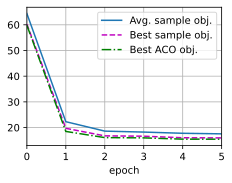

In [ ]:
n_node, n_ants = 50, 50
steps_per_epoch = 128
epochs = 50
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for CVRP500: 

total training duration: 1053.3798639774323
epoch -1: (273.7754501342773, 263.2929440307617, 260.8473345947266)
epoch 0: (115.62877433776856, 109.95573707580566, 108.50335960388183)
epoch 1: (69.69951522827148, 66.9304239654541, 65.51032752990723)
epoch 2: (73.55992790222167, 70.5244384765625, 69.09001358032226)
epoch 3: (68.85360900878906, 65.97909473419189, 64.72845714569092)
epoch 4: (68.78896701812744, 66.25900177001954, 65.23113815307617)


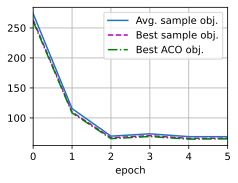

In [ ]:
n_node, n_ants = 100, 50
steps_per_epoch = 128
epochs = 50
train(n_node, n_ants, steps_per_epoch, epochs)